# TSARNN Homework 3 - Maximilian Rokuss and Julius Meyer-Ohlendorf




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import chi2
from scipy.stats import poisson

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
location = '/content/drive/MyDrive/Colab Notebooks/TSARNN/TSARNN_data/'#'/content/drive/MyDrive/Colab Notebooks/TSARNN/TSARNN_Ex3/'


### **Task 1**

The following function calculates the log likelihood according to (7.34) from the lecture script: $\log \mathrm{L}\left(\theta\right)=-\frac{T-p}{2} \log (2 \pi)-\frac{T-p}{2} \log \left(\sigma^{2}\right)-\frac{1}{2} \varepsilon^{T} \varepsilon \sigma^{-2}$


In [23]:
def Log_like(residuals, df, p):
    """
    Calculates  log-likelihood according to (7.34)
    """
    T = len(df)
    std = np.std(residuals[p+1:])
    print(std)
    epsilon = residuals[p+1:]
    Epsilon = np.sum((epsilon)**2)

    logLike = (-(T-p)/2 * np.log(2 * np.pi) - (T-p)/2 * np.log(std**2)
              - 1/2 * Epsilon * 1/(std**2))

    return(logLike)

# loading data
df = pd.read_excel(location + 'ex3file1.xls')

df1 = np.array(df['DLPFC1'])
df = np.array(df)


##1.1)

In [24]:
modelAR_4 = ARIMA(df1, order=(4,0,0))
model_fit_4 = modelAR_4.fit()
residuals_4 = model_fit_4.resid
Loglike = Log_like(residuals_4, df1, p=4)
print('Our Loglike:', Loglike)
print('Statsmodels Loglike:', model_fit_4.llf )

0.6768868253126014
Our Loglike: -365.71613013678916
Statsmodels Loglike: -371.70907752450375


There exists a small difference between the log likelihood value calculated with our function compared to the returned value from statsmodel.

## 1.2)

Determining the optimal order p of the AR model:

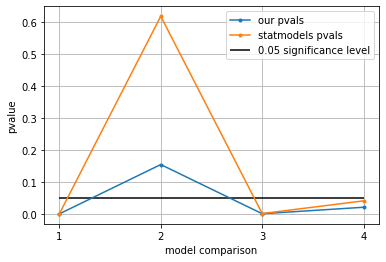

In [ ]:
arr_p1 = np.array([1, 2, 3, 4])
arr_p2 = np.array([2, 3, 4, 5])

pvals =  []
pvals_ARIMA = []

for p1, p2 in zip(arr_p1, arr_p2):
    modelAR_1 = ARIMA(df1, order=(p1,0,0))
    modelAR_2 = ARIMA(df1, order=(p2,0,0))
    model_fit_1 = modelAR_1.fit()
    model_fit_2 = modelAR_2.fit()

    residuals_1 = model_fit_1.resid
    residuals_2 = model_fit_2.resid

    Log_like_1 = Log_like(residuals_1, df1, p=p1)
    Log_like_2 = Log_like(residuals_2, df1, p=p2)
    Log_like_1_ARIMA = model_fit_1.llf
    Log_like_2_ARIMA = model_fit_2.llf

    # Test statistics
    ratio_Tstat = -2 * (Log_like_1 - Log_like_2)
    ratio_ARIMA_Tstat = -2 * (Log_like_1_ARIMA - Log_like_2_ARIMA)

    # calculating pvalues
    pval = 1 - chi2.cdf(ratio_Tstat, df=1)
    pval_ARIMA = 1 - chi2.cdf(ratio_ARIMA_Tstat, df=1)
    pvals.append(pval)
    pvals_ARIMA.append(pval_ARIMA)


xvals = [1, 2, 3, 4]
plt.figure(0)
plt.plot(xvals, pvals, '.-', label='our pvals')
plt.plot(xvals, pvals_ARIMA, '.-', label='statmodels pvals')
plt.hlines(0.05, 1, 4, label='0.05 significance level')
plt.ylabel('pvalue')
plt.xlabel('model comparison')
plt.xticks(xvals)
plt.legend()
plt.grid()
plt.show()

The values of the xaxis correspond to the model comparison order, e.g a value of 1 corresponds to the comparison of AR(1) with AR(2).

Again it is visible that there exist differences betwenn our pvalues and the ones based on the log likelihood from statsmodels. But both results lead to the same conclusion. For p=1 the Ho: AR(p) is already not rejected in favor of H1: AR(p+1) at a 0.05 significance level. Hence the log likelihood ration test leads to the conclusion that the AR(1) model is the best model. 

### **Task 2**

In [ ]:
# make a VAR model

model = VAR(df)

results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Dec, 2020
Time:                     17:17:35
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -1.53904
Nobs:                     359.000    HQIC:                  -1.66935
Log likelihood:          -1702.51    FPE:                   0.172843
AIC:                     -1.75538    Det(Omega_mle):        0.163540
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.002490         0.039307            0.063           0.949
L1.y1         0.906687         0.028281           32.060           0.000
L1.y2        -0.020353         0.036711           -0.554           0.579
L1.y3         0.015690

The off diagonal coefficients in the VAR matrix (given by four times the L1.y1-4 values not the matrix above) show the correlation between the four time series and the diagonal coefficients show the depencency of each time series on itself. So as one can see there exists a positive coupling between the DLPFC and the parietal cortex.

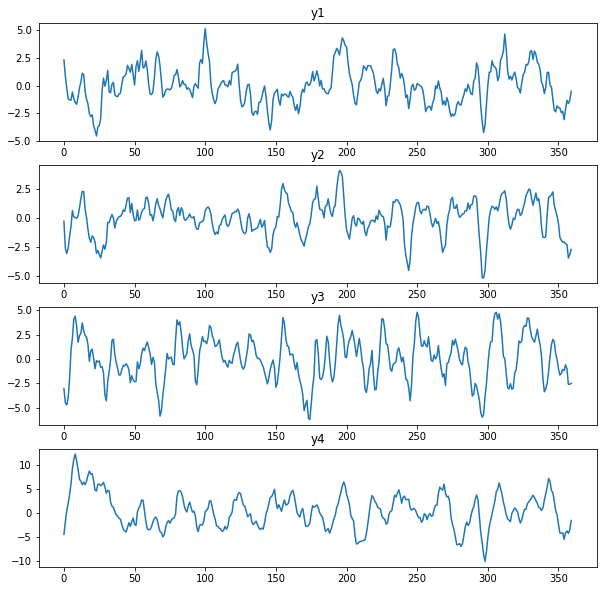

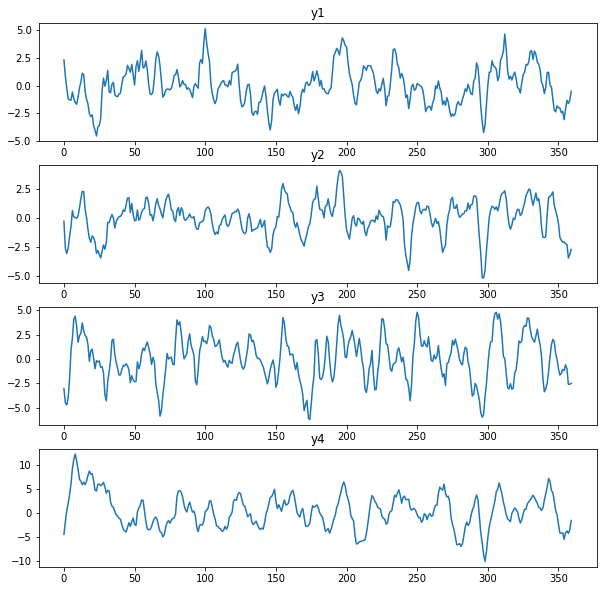

In [ ]:
results.plot()

By eyeballing the process looks stationary.



### **Task 3**

## 3.1)

In [ ]:
A1 = np.array([[0.2, -0.1], [0.1, 0.1]])
A2 = np.array([[0.1, -0.1], [0.1, 0.1]])
mu_0 = np.array([0.5, 0.5])
a_0 = np.array([0, 0])

T = 1000

The following function creates an order 2 Poisson TS:

In [ ]:
def TS_generator(A1, A2, mu_0, T):
    """
    Generates Poisson TS
    """
    c_t = np.zeros((2, T))

    # calculating c_0 and c_1 by hand
    c0 = np.random.poisson(mu_0)
    c_t[:,0] = c0
    mu_1 = np.exp(A1 @ c_t[:,0])
    c1 =  np.random.poisson(mu_1)
    c_t[:,1] = c1

    for t in range(2, T):
        mu = np.exp(A1 @ c_t[:,t-1] + A2 @ c_t[:,t-2])
        c_t[:,t] = np.random.poisson(mu)

    return(c_t)

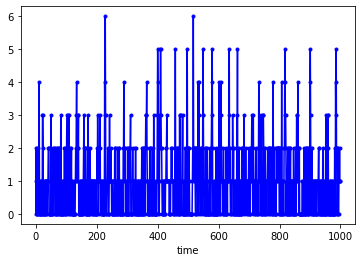

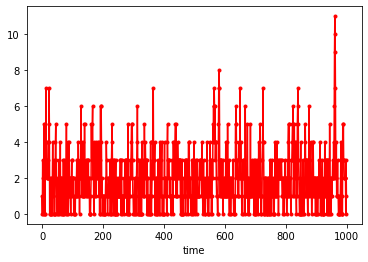

In [ ]:
c_t = TS_generator(A1, A2, mu_0, T)

plt.figure(0)
plt.plot(c_t[0], '.-', color='b')
plt.xlabel('time')
plt.show()

plt.figure(1)
plt.plot(c_t[1], '.-', color='r')
plt.xlabel('time')
plt.show()

## 3.2)

The following function calculates the log likelihood:

In [ ]:
def logLike_func(c_t, A1, A2, T):
    """
    Calculates log likelihood for a specific c_t given the paramters
    """
    log_like = 0
    for t in range(2, T):
        mu_t = np.exp(A1 @ c_t[:,-1] + A2 @ c_t[:,-2])
        log_like += np.sum(c_t[:,t] * np.log(mu_t) - mu_t)

    return(log_like)


log_like = logLike_func(c_t, A1, A2, T)
print('log_like:', log_like)

log_like: -1696.102305989607


This is the likelihood value calculated with the real paramter values of the generated data c_t. Hence, this value should correspond to the maximum of the likelihood landscape in the following.

In [ ]:
# varying the parameters
A1_11_arr = np.arange(0, 0.4, 0.01)
A2_21_arr = np.arange(0, 0.4, 0.01)

logLike_arr = np.zeros((len(A1_11_arr), len(A2_21_arr)))


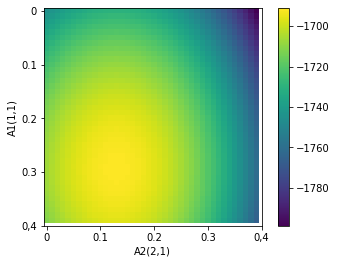

In [ ]:
for i, a1 in enumerate(A1_11_arr):
    #print('i', i)
    for j, a2 in enumerate(A2_21_arr):
        A1_new = np.array([[a1, -0.1], [0.1, 0.1]])
        A2_new = np.array([[0.1, -0.1], [a2, 0.1]])
        log_like = logLike_func(c_t, A1_new, A2_new, T)
        logLike_arr[i,j] = log_like


fig, ax = plt.subplots()
im = ax.imshow(logLike_arr)
ax.set_xlabel('A2(2,1)')
ax.set_ylabel('A1(1,1)')
ax.set_xticks([0, 10, 20, 30, 40])
ax.set_xticklabels(['0','0.1','0.2','0.3', '0,4'])
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_yticklabels(['0','0.1','0.2','0.3', '0,4'])
plt.colorbar(im)
plt.show()

The real paramter pair log likelihood value at A1(1,1)=0.2 and A2(2,1)=0.1 roughly corresponds to the maximum of the likelihood landscape, as this is the pair used to generate the TS c_t.